In [1]:
%%time
import gzip
from tensorflow.keras.utils import to_categorical

CPU times: user 2.35 s, sys: 1.17 s, total: 3.52 s
Wall time: 1.47 s


In [2]:
%%time
# Useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.version.version
np.seterr(all="ignore")

CPU times: user 125 ms, sys: 1.63 ms, total: 126 ms
Wall time: 127 ms


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
%%time
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, OneQubitEulerDecomposer
from qiskit import  Aer, transpile, IBMQ, assemble
from qiskit.circuit.library import CHGate
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.operators import PrimitiveOp, CircuitStateFn
from qiskit.aqua.operators.primitive_ops import MatrixOp
from qiskit.aqua.operators.converters import CircuitSampler
from qiskit.aqua.operators.expectations import MatrixExpectation # factory or matirx?
from qiskit.aqua.operators.list_ops import ComposedOp
from qiskit.aqua.operators import ListOp
from qiskit.aqua.components.initial_states import Zero
import qiskit

CPU times: user 868 ms, sys: 72 ms, total: 940 ms
Wall time: 887 ms


In [4]:
%%time
# from Lie_alge.Sophus.py.sophus import so2, so3
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.pca import TangentPCA

INFO: Using numpy backend


CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 107 ms


In [5]:
%%time
provider = IBMQ.load_account()

__init__.discover_credentials:INFO:2021-05-04 09:28:22,415: Using credentials from qiskitrc


CPU times: user 65 ms, sys: 21.7 ms, total: 86.7 ms
Wall time: 2.52 s


In [6]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [7]:
%%time
# print(Aer.backends())
simulator = Aer.get_backend("statevector_simulator")
# simulator.set_option(method=)
my_sampler = CircuitSampler(backend=simulator, attach_results=True, param_qobj=False)  # read up on this more
my_expectation = MatrixExpectation()

CPU times: user 1.81 ms, sys: 628 µs, total: 2.44 ms
Wall time: 2 ms


/home/john/.local/lib/python3.9/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',


In [8]:
%%time
# EMNIST decoder

decoder = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [9]:
%%time
images_raw = gzip.open("data/MNIST/MNIST_GZ/train-images-idx3-ubyte.gz", "r")
labels_raw = gzip.open("data/MNIST/MNIST_GZ/train-labels-idx1-ubyte.gz")


image_size = 28
num_images = 4096 # how many images per batch

images_raw.read(16) # reads the data type
labels_raw.read(8) # reads the data type

def get_data(images, labels):
    buf_images = images.read(image_size * image_size * num_images)
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(num_images, image_size, image_size, 1)
    
    buf_labels = labels.read(num_images)
    labels = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int32)
    
    return images, labels

CPU times: user 1.52 ms, sys: 527 µs, total: 2.05 ms
Wall time: 5.26 ms


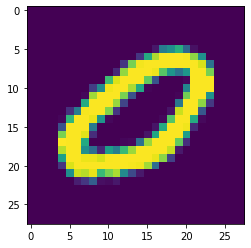

0
CPU times: user 106 ms, sys: 10.7 ms, total: 117 ms
Wall time: 143 ms


In [10]:
%%time
# print images
data = get_data(images_raw, labels_raw)

images = data[0]
labels = data[1]



sort_index = np.argsort(data[1], axis=0)

sorted_images = data[0][sort_index]
sorted_labels = data[1][sort_index]

sorted_data = sorted_images, sorted_labels

image = np.asarray(sorted_images[1]).T.squeeze()
plt.imshow(image)
plt.show()

print(decoder[sorted_labels[1]])

In [11]:
%%time
np.set_printoptions(threshold=2 ** 10 + 1)
print(sorted_labels)

[0 0 0 ... 9 9 9]
CPU times: user 392 µs, sys: 0 ns, total: 392 µs
Wall time: 264 µs


In [12]:
%%time
def get_num_cls(data):
    labels = np.array(data[1])
    one_hot_labels = to_categorical(labels)
    
    return one_hot_labels.shape[1]


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [13]:
%%time
N = get_num_cls(data)
print(N)

10
CPU times: user 553 µs, sys: 188 µs, total: 741 µs
Wall time: 443 µs


In [14]:
class AdamOptim():
    """From https://towardsdatascience.com/how-to-implement-an-adam-optimizer-from-scratch-76e7b217f1cc"""
    def __init__(self, num_of_keys=1, eta=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m_dw = {key: 0 for key in range(num_of_keys)}
        self.v_dw = {key: 0 for key in range(num_of_keys)}
        self.m_db, self.v_db = 0, 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self, key, t, w, b, dw, db):
        ## dw, db are from current minibatch
        ## momentum beta 1
        # *** weights *** #
        self.m_dw[key] = self.beta1*self.m_dw[key] + (1-self.beta1)*dw
        # *** biases *** #
        self.m_db = self.beta1*self.m_db + (1-self.beta1)*db

        ## rms beta 2
        # *** weights *** #
        self.v_dw[key] = self.beta2*self.v_dw[key] + (1-self.beta2)*(dw**2)
        # *** biases *** #
        self.v_db = self.beta2*self.v_db + (1-self.beta2)*(db)

        ## bias correction
        m_dw_corr = self.m_dw[key]/(1-self.beta1**t + self.epsilon)
        m_db_corr = self.m_db/(1-self.beta1**t + self.epsilon)
        v_dw_corr = self.v_dw[key]/(1-self.beta2**t + self.epsilon)
        v_db_corr = self.v_db/(1-self.beta2**t + self.epsilon)

        ## update weights and biases
        w = w + self.eta*(m_dw_corr/(np.sqrt(v_dw_corr)+self.epsilon)) # changed this to a - from a + for the first two terms
        b = b + self.eta*(m_db_corr/(np.sqrt(v_db_corr)+self.epsilon)) # changed this to a - from a + for the first two terms
        return w, b

In [15]:
# %%time

class Forward_and_backward:
    """see:
        https://arxiv.org/pdf/1908.08385.pdf
        equations 1 and 2
        also see:
        https://qiskit.org/documentation/stubs/qiskit.circuit.library.CHGate.html
    """
    def __init__(self, N, data, num_of_it):
        """"""
        self.num_of_it = num_of_it
        self.target_N = N
        self.N = self.target_N - 1
        self.data = data
        self.alpha = np.arange(start=1, stop=self.target_N ** 2 + 1, dtype=np.complex_) # kind of like biases
        # self.K = 1
        # self.P = []
        # self.P_idx = 0
        self.total_error = {}
        self.Ek = {}
        self.set_lie_alge = True
    
    def H(self):
        """"""
        euler = self.A() * self.SU_of_Nm1(self.target_N) * np.exp(1j * np.sum(self.lie_alge) * np.sum(self.alpha))
        
        # print("A = ", self.A())
        # print("SU N - 1 = ", self.SU_of_Nm1(self.target_N))
        # print("NP.exp = ", np.exp(1j * np.sum(self.lie_alge) * np.sum(self.alpha)))
        # print("lie", np.sum(self.lie_alge))
        # print("alpha", np.sum(self.alpha))
        
        # print(euler)
        euler = OneQubitEulerDecomposer("ZYZ").angles(euler)
        
        # print(euler)
        
        def map_circuit(k, qc_k):
            """"""
            for i in range(self.target_N):
                try:
                    qc_k.cx(k, i) @ (np.asarray(euler)[np.newaxis]).T
                except:
                    #print(qc_k)
                    continue

        qr = QuantumRegister(self.target_N, "qreg")
        qc_k = QuantumCircuit(qr, name="qc_k")
        # print(type(qc_k))
        
        
        
        for k in range(1, self.target_N + 1):
            qc_k.initialize([np.sqrt(1/2), np.sqrt(1/2)], qubits=k - 1) # might be 1, 0
        
        for k in range(self.target_N):  # has to be seperate loop to have h gate be first
            map_circuit(k, qc_k)
            # END ROTATIONS
            # qc_k.h(k)
        
            
        
        # self.cr_k = ClassicalRegister(self.target_N, name="cr_k")
        # self.qc_k.add_register(self.cr_k)
        op = PrimitiveOp(qc_k)
        # print(op.num_qubits)

        h = []
        for i in range(self.x.shape[2]):
            # row = []
            # for k in range(self.target_N ):  # REMOVE THIS?
                # row.append(op)
            h.append(op) # was row
            # print("term1 = ", term1)

            # h.append(row)
            # row.append(h)
            # print(h[i])
            
        vec_0 = np.zeros(shape=(self.target_N, self.target_N), dtype=np.complex_)
        vec_0[0, 0] = 1
        vec_0 = np.asmatrix(vec_0).H
        vec_0 = np.asarray(vec_0) # might help it go faster?
            
        h = np.asarray(h, dtype=object)[:np.newaxis]
        # print("h shape = ", h.shape)
        H_op = np.asarray(h / np.sqrt(self.target_N, dtype=np.complex_), dtype=object) 

        # print(H_op.shape)
        # print(vec_0.shape)
        
        # H_op= H_op @ vec_0
        
        # print("h_op =", H_op.shape)
        
        return H_op
        
    def quNit(self, SU_of_N):
        # qr = QuantumRegister(self.target_N, 'a')
        
        S3 =np.zeros(shape=(self.target_N, self.target_N), dtype=np.complex_)
        np.fill_diagonal(S3, -(self.target_N - 1) / 2)
        # print(self.x.shape)
        # print(self.W[self.i].shape)
        sum_of_weights = np.sum(np.asarray([w @ x for w, x in zip(self.W[self.i], self.x)]), axis=0)
        # print(sum_of_weights)
        Z = np.exp((1j) * S3) 
        
        # print("weights = ", sum_of_weights.shape)

        self.lie_alge = self.lie_algebra(SU_of_N)
        
        qn = Z @ (sum_of_weights @ self.H()).T
        # print("QN shape = ", qn.shape)
        return qn # init state should be 0

 ##################################################   

    def A(self):
        a = []
        epsilon = 1e-08
        # print(lie_alge.shape)
        
        for k in range(2, self.target_N + 1):
            
            val = np.exp(1j * self.lie_alge[3] * self.alpha[2 * k - 3] * np.exp(1j * self.lie_alge[((k - 1) ** 2 + 1)] * self.alpha[2 * (k - 1)]))
            
            a.append(val + epsilon) 
        
        
        # print("A.shape = ", a.shape)
        
        return np.prod(a) 

    def SU_of_Nm1(self, n):
        n -= 1
        son = SpecialOrthogonal(n=n, point_type='matrix')
        # print(son)
        metric = son.bi_invariant_metric

        data = son.random_uniform(n_samples=(self.target_N))

        tpca = TangentPCA(metric=metric, n_components=(self.target_N))  ## SELF.TARGET_N?
        tpca = tpca.fit(data)
        tangent_projected_data = tpca.transform(data)
        return tangent_projected_data
    
    def SU_of_N(self, n):
        """"""
        son = SpecialOrthogonal(n=n, point_type='matrix')
        # print(son)
        metric = son.bi_invariant_metric

        data = son.random_uniform(n_samples=(self.target_N))

        tpca = TangentPCA(metric=metric, n_components=(self.target_N))  ## SELF.TARGET_N?
        tpca = tpca.fit(data)
        tangent_projected_data = tpca.transform(data)
        return tangent_projected_data

    def lie_algebra(self, SU_N):
        """"""
        
        if self.set_lie_alge == True:
            self.set_lie_alge = False
            i = 0
            epsilon = 1e-10
            lie_algebras = []
            while i < self.target_N ** 2:
                print("working on lie algebra {} / {}".format(i, self.target_N ** 2))
                delta = epsilon * np.random.uniform(low=-1, high=1, size=(1))
                mat = np.full((self.target_N, self.target_N), delta)
                np.fill_diagonal(mat, 0)
                if not np.linalg.det(mat):
                    continue
                else:
                    i += 1
                    lie = mat 
                    lie_algebras.append(lie)
                    # print(lie)

            return np.asarray(lie_algebras, dtype= complex)

        else:
            return self.lie_alge
    ############################################
    
    
    def forward(self):
        """"""
        # init values for forward
        SU_N = self.SU_of_N(self.target_N)
        ket_x = self.quNit(SU_N)
        
        
        # weighted ket_x
        
        # print("before su(n)", ket_x.shape)
        # print(SU_N.shape)
        
        ket_x = SU_N @ ket_x
        
        # print("########KET X##########", ket_x)

        ket_x_list = []
        
        # print("after", ket_x.shape)
        # print(ket_x)

        for k, op in enumerate(ket_x):
            cr = ClassicalRegister(self.target_N, "creg{}".format(k))
            qc = my_expectation.convert(op)
            qc = qc.to_circuit()
            # qc.add_register(qr)
            qc.add_register(cr)
            qc.measure_all([val for val in range(self.target_N - 1)])
            qobj = assemble(qc, shots= 2 ** self.target_N)
            job = simulator.run(qobj)
            # data = job.result().data(self.qc)
            vec = job.result().get_statevector(qc, decimals=10)
            # print(vec)
            ket_x_list.append(vec)
        
        ket_x = np.asarray(ket_x_list)
        
        # print(ket_x)
        
        # print(ket_x)
        # print(ket_x.shape)
        
        
        def Purity(N, ket_x):
            """"""
            bra_x = np.asmatrix(ket_x).H
            
            return ((ket_x @ bra_x) / N) ** 2
            
        Pa = Purity(self.target_N, ket_x)
        # print(Pa)
        Pa = np.diag(Pa)
        print(Pa.shape)
        Pb = np.argmax(Pa)
        print("prediction = ", Pb)
        print("probs = ", Pa.real)

        return Pb, ket_x

    def backward(self, pred_dict):
        """"""
        SU_N = self.SU_of_N(self.target_N)
        qc = self.H()
        Mk = self.target_N # * self.target_N
        
        ket_x = pred_dict[decoder[self.i]][1]
        
        # print(ket_x.shape)
        
        Pk = np.sum((np.matrix(ket_x) @ np.matrix(ket_x).H)  / Mk)

        print(Pk.shape)
        print(SU_N.shape)
        
        Pk = np.asarray(np.asmatrix(SU_N) * Pk * np.asmatrix(SU_N).H, dtype=np.complex_)

        # print(qc.shape)
        
        # print("Pk after sun = ", Pk.shape)

        Pk = np.diagonal(Pk)
        
        # print(Pk)
        
        # back prop probs
        for i, value in enumerate(Pk):
            print("chance of {} = {}".format(i, (value.real) / Mk))
            
        
        self.Ek[self.i] = 1 - Pk

    def cost(self):
        Mk = self.target_N * self.target_N
        
        e = self.Ek[self.i]
        e /= Mk

        print("error shape =", e.shape)
        
        self.total_error[self.i] = e
    
        
    def train(self):
        """"""
        adam = AdamOptim(num_of_keys=self.target_N)
        pred_dict = {}
        init_W = True
        self.W = {}
        
        
        
        for i in range(self.target_N):
            for j in range(self.num_of_it):
                self.i = i
                print("working on {}s".format(decoder[i]))
                sorted_images = self.data[0]
                sorted_labels = self.data[1]
                # print(sorted_labels.shape)
                y = sorted_labels[sorted_labels == i]
                # print(y)
                self.x = sorted_images[sorted_labels == i]

                try:
                    # print(self.x.shape)
                    self.x = self.x.squeeze(axis=(0, -1))
                    # print(self.x.shape)
                except(ValueError):
                    # print(self.x.shape)
                    self.x = self.x.squeeze(axis=-1)
                    # print(self.x.shape)

                """image = self.x[0]
                plt.imshow(image)
                plt.show()"""

                if init_W:
                    print("init W")
                    self.W[self.i] = np.random.random(size=(self.x.shape[0], self.target_N, self.x.shape[2])) # learnable similar to weights

                pred_dict[decoder[i]] = self.forward()
                self.backward(pred_dict)
                self.cost()

                print(self.total_error[self.i])
                
                dw = (np.asarray([w @ w.T for w in self.W[self.i]], dtype=np.complex_) @ self.total_error[self.i])[:, :, np.newaxis]
                db = self.alpha  @ self.alpha.T * np.sum(self.total_error[self.i])

                self.W[self.i], self.alpha = adam.update(key=i, t=j, w=self.W[self.i], b=self.alpha, dw=dw, db=db)
                print("error = ", self.total_error[self.i].real)

                init_W = False
        init_W = True
                
            

In [16]:
# %time
train = Forward_and_backward(N, sorted_data, 25)

In [ ]:
%%time
train.train()

working on 0s
init W
working on lie algebra 0 / 100
working on lie algebra 1 / 100
working on lie algebra 2 / 100
working on lie algebra 3 / 100
working on lie algebra 4 / 100
working on lie algebra 5 / 100
working on lie algebra 6 / 100
working on lie algebra 7 / 100
working on lie algebra 8 / 100
working on lie algebra 9 / 100
working on lie algebra 10 / 100
working on lie algebra 11 / 100
working on lie algebra 12 / 100
working on lie algebra 13 / 100
working on lie algebra 14 / 100
working on lie algebra 15 / 100
working on lie algebra 16 / 100
working on lie algebra 17 / 100
working on lie algebra 18 / 100
working on lie algebra 19 / 100
working on lie algebra 20 / 100
working on lie algebra 21 / 100
working on lie algebra 22 / 100
working on lie algebra 23 / 100
working on lie algebra 24 / 100
working on lie algebra 25 / 100
working on lie algebra 26 / 100
working on lie algebra 27 / 100
working on lie algebra 28 / 100
working on lie algebra 29 / 100
working on lie algebra 30 / 1